# Class Activation Map 만들기

1. CAM 용 classification 모델 준비하기
2. CAM
3. Grad-CAM
4. Detection with CAM

## 데이터셋 준비하기
* `Localization` + `Classification` -> `stanford_dogs`

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    shuffle_files=True,
    with_info=True
)

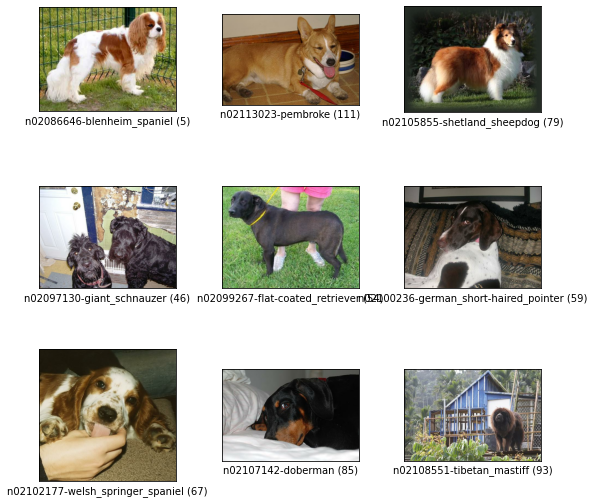

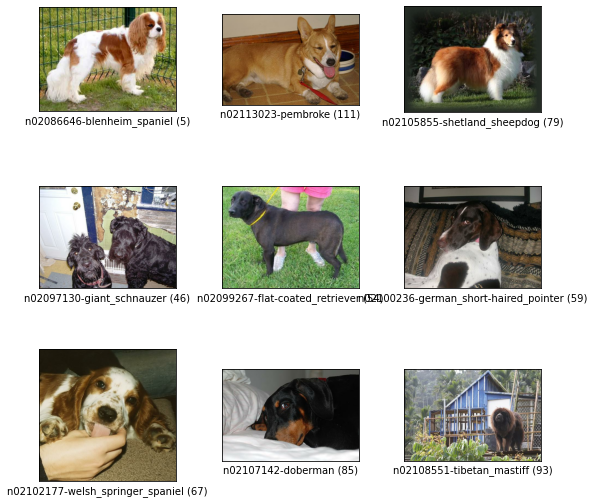

In [4]:
tfds.show_examples(ds_train, ds_info)

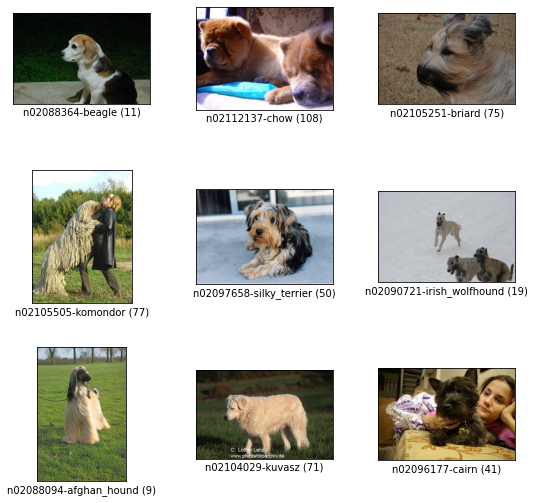

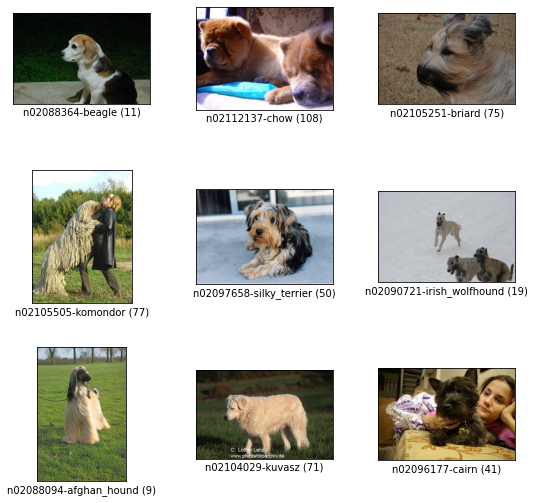

In [5]:
tfds.show_examples(ds_test, ds_info)

## Localization
### Bounding Box
* `xywh`
* `minmax`
* `LRTB`, `QUAD`, ...

In [6]:
# 메타데이터 -> ds_info
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## CAM을 위한 모델 만들기
`ResNet50` -> `fully connected layer` 제거 -> `GAP`, `softmax 레이어` 추가

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### 모델 학습하기
* `normalize_and_resize_img()`
* `apply_normlize_on_dataset()`: Batch 구성

In [9]:
def normalize_and_resize_img(input):
    # normalizes images 'uint8' -> `float32`
    image = tf.image.resize(input['image'], [224,224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/15
750/750 [==============================] - 369s 447ms/step - loss: 3.2186 - accuracy: 0.2775 - val_loss: 3.1270 - val_accuracy: 0.2495
Epoch 2/15
750/750 [==============================] - 345s 461ms/step - loss: 0.9080 - accuracy: 0.7390 - val_loss: 1.1111 - val_accuracy: 0.6812
Epoch 3/15
750/750 [==============================] - 333s 445ms/step - loss: 0.2912 - accuracy: 0.9345 - val_loss: 0.9799 - val_accuracy: 0.7145
Epoch 4/15
750/750 [==============================] - 334s 445ms/step - loss: 0.0897 - accuracy: 0.9901 - val_loss: 0.9235 - val_accuracy: 0.7327
Epoch 5/15
750/750 [==============================] - 334s 445ms/step - loss: 0.0372 - accuracy: 0.9978 - val_loss: 0.9155 - val_accuracy: 0.7404
Epoch 6/15
750/750 [==============================] - 334s 445ms/step - loss: 0.0186 - accuracy: 0.9996 - val_loss: 0.9100 - val_accuracy: 0.7451
Epoch 7/15
750/750 [==============================] - 334s 445ms/step - loss: 0.0130 - accuracy: 0.9998 - val_loss: 0.9199 -

KeyboardInterrupt: 

In [13]:
import os

cam_model_path = os.getenv("HOME") + '/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("Save complete!")

Save complete!


In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

11


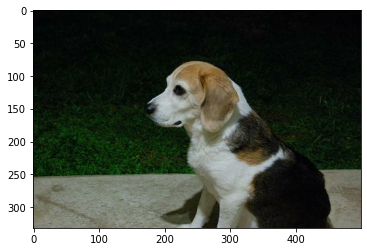

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### 이전에 학습한 모델 불러오기

In [16]:
import os
cam_model_path = os.getenv("HOME") + '/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

* CAM을 생성하기 위해서는 (1) 특성맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, (3) 원하는 클래스의 출력값이 필요함.
* 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야함

In [17]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # model.layer[-3].output 에서 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있음.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]  # 마지막 모델의 weight activation 을 가져옵니다
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W*f 를 통해 class 별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]
    
    cam_image /= np.max(cam_image)   # activation score를 normalize 합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))   # 원래 이미지 크기로 resize
    return cam_image

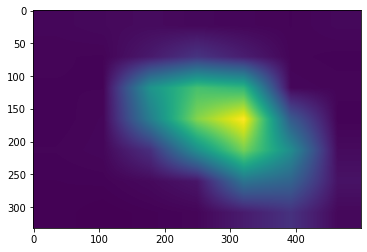

In [18]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

* 그려진 CAM 이미지를 원본 이미지와 합쳐 확인한다

In [19]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

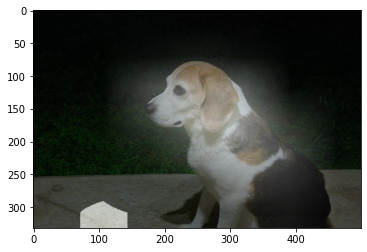

In [20]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

---
## Grad-CAM
* 관찰을 원하는 `activation_layer`와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 레이어의 채널별 가중치를 구함. -> 원하는 레이어의 `output`과 특정 클래스의 prediction 사이의 그래디언트 `grad_val`를 얻고 이를 `weights`로 활용함

84


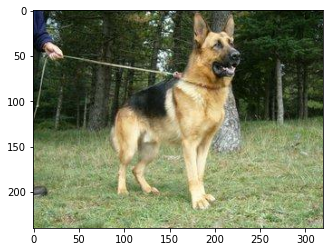

In [21]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [22]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

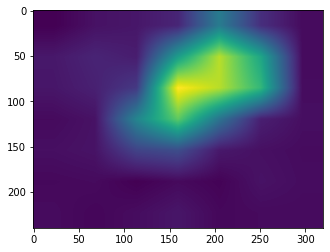

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

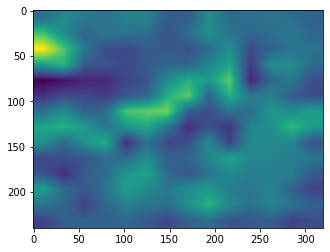

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

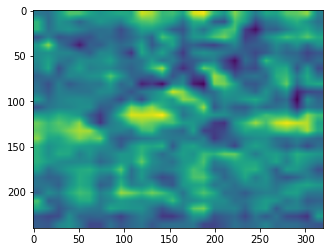

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

---
## Detection with CAM
### Bounding Box

100


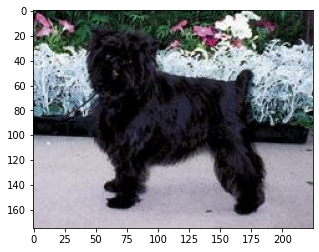

In [26]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

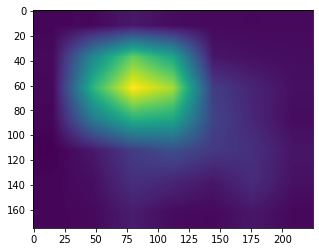

In [27]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

* `get_bbox()` 함수는 바운딩 박스를 만들기 위해 `score_thresh`를 받아 역치값 이하의 바운딩 박스를 없앱니다. 그 다음 openCV의 `findContours()`와 `minAreaRect()`로 사각형을 찾습니다. 이때 `rotated_rect`라는 회전된 바운딩 박스를 얻을 수 있습니다. `boxPoints()`로 이를 꼭지점으로 바꾸어 줍니다. 마지막으로 `int` 자료형으로 변환해줍니다.

In [28]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [29]:
rect = get_bbox(cam_image)
rect

array([[  7,  10],
       [184, -16],
       [210, 154],
       [ 34, 182]])

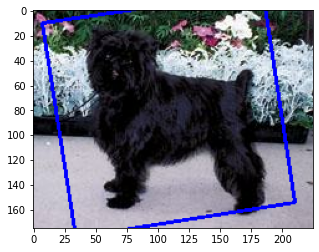

In [30]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Intersection Over Union
* 바운딩 박스의 정확도를 계산
* IOU = Area of Overlap / Area of Union

In [33]:
# rect 의 좌표는 (x,y), bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다
def rect_to_minmax(rect, image):
    bbox =  [
        rect[:,1].min()/float(image.shape[0]),   # y_min
        rect[:,0].min()/float(image.shape[1]),   # x_min
        rect[:,1].max()/float(image.shape[0]),   # y_max
        rect[:,0].max()/float(image.shape[1]),   # x_max
    ]
    return bbox

In [34]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.09142857142857143, 0.03111111111111111, 1.04, 0.9333333333333333]

In [35]:
item['objects']['bbox']

array([[0.08      , 0.16444445, 0.94857144, 0.84      ]], dtype=float32)

In [36]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou
    

In [37]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5748121762724131